# _ARIEL_

# Table of Contents

0. [Import and installation requirements](#section0)
1. [Asserting that the model is coherent](#section1)
2. [Drawing simple geometric figures](#section2)
3. [Drawing simplified images](#section3)
4. [Drawing complex images](#section4)
5. [Drawings based on images imported by the user](#section5)

# Introduction

This notebook will allow you to explore the different possibilities offered by ARIEL. In the first section we display a few tests who helped us create the model and verify that it was relevant to solve our problem. In the sections ranging from 2 to 4 we display the results obtained for images with increasing complexity. In the last section you can specify the URL of any image you want to see ARIEL draw for you and enjoy the result!

<a id='section0'></a>

# Importing necessary python packages

You will need the following packages to run ARIES: 

- Pillow
- torch
- torchvision
- matplotlib
- numpy
- tqdm

If you are not sure you have them all installed (on the python version used for the kernel of this jupyter notebook), run the following cell:

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

The following cell is mandatory

In [1]:
from model_encoder import *
from optim_draw import *
import urllib.request 

<a id='section1'></a>

# Asserting the model's coherence

### Blurrying lines in order to simplify the optimization

CNNs treat the information locally, the problem is that if we only deal with extremely thin straight lines, if the line we are drawing is not initially extremely close to the target line we are trying to draw then we won't be able to optimize the parameters of the drawn line. Indeed outside of a very small sphere of pixels around the reference line, being 10 pixels or 60 pixels away from the target line doesn't make any difference from the point of view of the CNN's comparison loss. Since the gradient of the comparison loss will be zero, we won't be able to move step by step the drawn line closer to the target line by using a gradient descent.

This is why we decided to draw wider lines and to add a decay parameter so that each drawn line actually affects several pixels around it and is less restrictively localized.

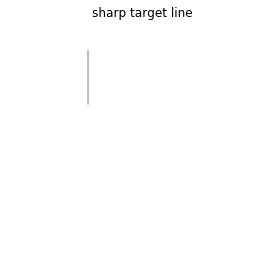

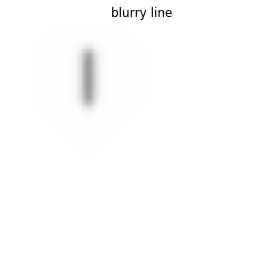

In [19]:
from model_benchmark import *

target_image = get_1line_image(32, 16, 32, 48, sharp=True)
blurry_image = get_1line_image(32, 16, 32, 48, sharp=False)

cnn = CNNFeatureExtractor()
for param in cnn.model.parameters():  # the cnn feature extractor has already been trained, we freeze its parameters
    param.requires_grad = False
cnn.add_comparison_loss(target_image)

losses_without_blurryness = []
losses_with_blurryness = []
for k in range(30):
    sharp_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=True)
    losses_without_blurryness.append(cnn.comparison_loss(cnn.model(sharp_drawing)))
    blurry_drawing = get_1line_image(32 + k, 16, 32 + k, 48, sharp=False)
    losses_with_blurryness.append(cnn.comparison_loss(cnn.model(blurry_drawing)))
    

imshow(target_image, title="sharp target line")
imshow(blurry_image, title="blurry line")

Above you can see the 'sharp' target line to which we are going to compare each drawn line. Below it is displayed the kind of lines we draw.

With the following cell we show the impact of blurrying lines on the ability of the CNN to detect when the drawn line is close to its target. We see that the gradient is different than zero for a larger area in terms of pixels than we don't use the blurrying trick.

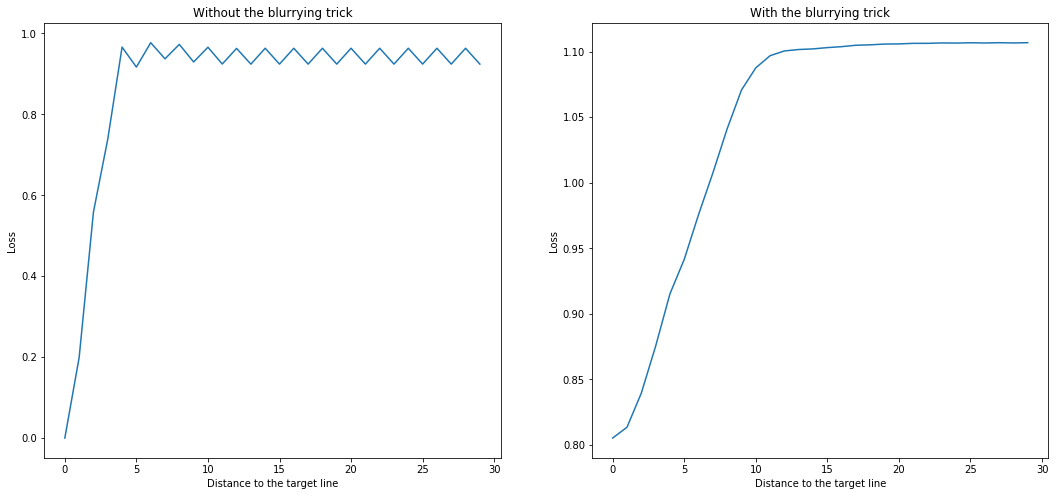

In [20]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses_without_blurryness)), losses_without_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("Without the blurrying trick")
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(losses_with_blurryness)), losses_with_blurryness)
plt.xlabel("Distance to the target line")
plt.ylabel("Loss")
plt.title("With the blurrying trick")
plt.show()

We show here using the simple example where the target image is just a single line that when we use the blurrying trick, the optimization of the coordinates of the line we draw works perfectly.

/home/jules/PycharmProjects/smart_drawing/model_encoder.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jules/PycharmProjects/smart_drawing/model_encoder.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Drawing line number 0
Initializing the line..
Current best line initialization loss:  7.98099946975708
Current best line initialization loss:  7.962740898132324
Current best line initialization loss:  7.8468780517578125
Current best line initialization loss:  7.795413494110107
Current best line initialization loss:  6.491214275360107


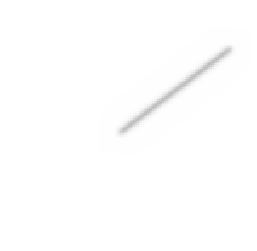

  2%|▏         | 1/50 [00:00<00:08,  5.52it/s]

Optimizing the line..


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Final loss :  4.615024566650391


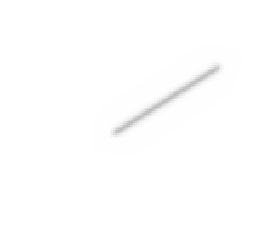

Drawing line number 1
Initializing the line..
Current best line initialization loss:  5.2476911544799805
Current best line initialization loss:  4.938947677612305
Current best line initialization loss:  4.900909423828125
Current best line initialization loss:  4.876224040985107
Current best line initialization loss:  4.785358905792236
Current best line initialization loss:  4.755486011505127


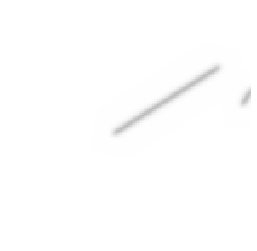

  0%|          | 0/50 [00:00<?, ?it/s]

Optimizing the line..


100%|██████████| 50/50 [00:09<00:00,  6.02it/s]


Final loss :  4.599245548248291


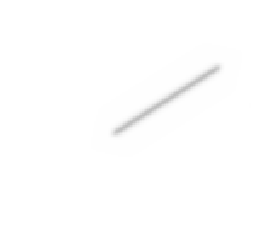

Drawing line number 2
Initializing the line..
Current best line initialization loss:  5.343977451324463
Current best line initialization loss:  5.170558452606201
Current best line initialization loss:  4.994431495666504
Current best line initialization loss:  4.921154022216797
Current best line initialization loss:  4.875649452209473
Current best line initialization loss:  4.808811187744141
Current best line initialization loss:  4.718249320983887


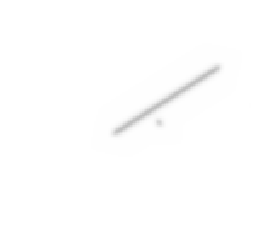

  2%|▏         | 1/50 [00:00<00:07,  6.32it/s]

Optimizing the line..


100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Final loss :  4.5999555587768555


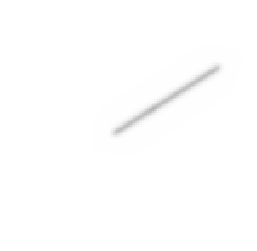

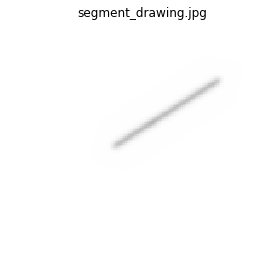

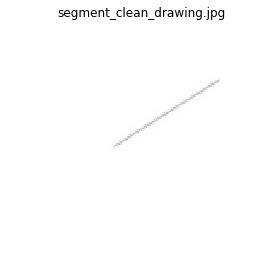

In [2]:
imshow(image_loader("./Images/segment.jpg"), title="The target image")
n_epochs = 50
drawer = run(image_loader("./Images/segment.jpg"), 1, n_epochs, clean=True, save=False, save_title='segment')

We display here the comparison loss between the target image and the unfinished drawing at every step of the optimization. We see that the blurrying trick allows the gradient descent to converge. We also observe that initializing randomly and selecting the best initialization is not enough in order to draw the target image, the optimization step of the drawing is also necessary since it allows to considerably reduce the comparison loss between the target image and the drawing.

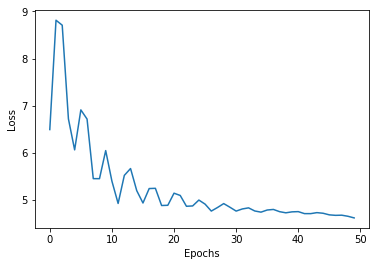

In [3]:
history = drawer.loss_history
plt.figure()
plt.plot(np.arange(n_epochs), history[:n_epochs])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Using ARIEL

Here are displayed several examples of drawings done by ARIEL, the function ```run``` is what actually runs the computation of the drawing, it has many arguments we will describe here:
- ```n_lines``` is an integer that corresponds the number of straight lines used to draw the sketch, it is determined before the drawing
- ```n_epochs``` is an integer, it is the number of iterations in the optimization of each line
- ```clean``` is a boolean that determines whether or not we will show at the end of the computations another version of the drawing where the lines will have been "unblurried"
- ```save``` is a boolean that indicates whether you want to save the final drawing
- ```save_title``` is a str that indicates the path here you would like to save the results if save were True (you don't need to add the .jpg extension to that path)

<a id='section2'></a>

# Drawing simple geometric figures

In [2]:
# imsize = 
# The default value for imsize is 128, you can uncomment the above line to give it any value you wish
# the higher it is the more details you will have but the drawing will take more time
# the expected runtime we give were obtained with imsize = 128

n_epochs = 40 # the number of iterations in the optimization of each line
print("The drawings will be done on a %i x %i canvas" % (imsize, imsize))

The drawings will be done on a 128 x 128 canvas


The target image:

In [ ]:
imshow(image_loader("./Images/losange.jpg"))

The drawing:

In [ ]:
n_lines = 10

In [ ]:
drawer = run(image_loader("./Images/losange.jpg"), n_lines, n_epochs, clean=True, save=False, save_title='losange')

The target image:

In [ ]:
imshow(image_loader("./Images/ovale.jpg"))

The drawing:

In [ ]:
n_lines = 50

In [ ]:
drawer = run(image_loader("./Images/ovale.jpg"), n_lines, n_epochs, clean=True, save=False, save_title='ovale')

### Combining thin lines to create thicker lines

An amusing discovery was that when the lines in the targer image were wider than the ones used by the drawer, it would add many lines to create something that looks like the original. Here is an example where it had to do that:

In [ ]:
imshow(image_loader("./Images/texte.jpg"))

In [ ]:
drawer = run(image_loader("./Images/texte.jpg"), 150, n_epochs, clean=True, save=False, save_title='hey')

### Coloring monochrome surfaces

The Drawer also intuitively colors monochrome surfaces by adding multiple lines, just as we would do with a pencil. Here is an example of this behaviour on a target image:

In [ ]:
n_lines = 250

In [ ]:
imshow(image_loader("./Images/ovale plein.jpg"))

In [ ]:
drawer = run(image_loader("./Images/ovale plein.jpg"), n_lines, n_epochs, clean=True, save=False, save_title='ovale plein')

<a id='section3'></a>

# Drawing simplified images

Before we try to draw complex images like real colored pictures, we first test the drawer on a simplified version of a picture of a boat. We feed it a black and white picture whose composed of straight lines only. Here is what it looks like:

In [ ]:
n_lines = 250

In [ ]:
imshow(image_loader("./Images/stickboat.jpg"))

In [ ]:
drawer = run(image_loader("./Images/stickboat.jpg"), n_lines, n_epochs, clean=True, save=False, save_title='stickboat')

<a id='section4'></a>

# Drawing complex images

In [ ]:
imshow(image_loader("./Images/boat.jpg"))

In [ ]:
drawer = run(image_loader("./Images/boat.jpg"), n_lines, n_epochs, clean=True, save=False, save_title='boat')

<a id='section5'></a>

# Drawing images imported by the user

In this section you can choose to have ARIES draw either: 
- an image that is saved locally on your computer by filling the variable img_path with the path to your image
or
- an image you found on the internet but didn't download yet by filling img_url with the url of your image

In [ ]:
img_url = ''
img_path = ''

In [ ]:
if img_url != '':
    urllib.request.urlretrieve(img_url, "./target_img.png")
    img_path = "./target_img.png"
# this cell downloads an image if you specified any url in img_url

The target image:

In [ ]:
imshow(image_loader(img_path))

The drawing:

In [ ]:
drawer = run(image_loader(img_path), n_lines, n_epochs, clean=True, save=False, save_title='')